In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Renaming y of the column by mapping each of the images to its output
# 0 - cavallo
# 1 - elefante
# 2 - farfalla
# 3 - gallina
# 4 - gatto

df1 = pd.read_csv('/content/cavallo.csv', header=None)
df1.rename(columns={0: 'y'}, inplace=True)
df1 = df1.assign(y=0)

df2 = pd.read_csv('/content/elefante.csv', header=None)
df2.rename(columns={0: 'y'}, inplace=True)
df2 = df2.assign(y=1)

df3 = pd.read_csv('/content/farfalla.csv', header=None)
df3.rename(columns={0: 'y'}, inplace=True)
df3 = df3.assign(y=2)

df4 = pd.read_csv('/content/gallina.csv', header=None)
df4.rename(columns={0: 'y'}, inplace=True)
df4 = df4.assign(y=3)

df5 = pd.read_csv('/content/gatto.csv', header=None)
df5.rename(columns={0: 'y'}, inplace=True)
df5 = df5.assign(y=4)

# Cleaning up the dataframe by deleting the last column
df1.drop(df1.columns[len(df1.columns)-1], axis=1, inplace=True)
df2.drop(df2.columns[len(df2.columns)-1], axis=1, inplace=True)
df3.drop(df3.columns[len(df3.columns)-1], axis=1, inplace=True)
df4.drop(df4.columns[len(df4.columns)-1], axis=1, inplace=True)
df5.drop(df5.columns[len(df5.columns)-1], axis=1, inplace=True)

frames = [df1, df2, df3, df4, df5]
df = pd.concat(frames)

In [3]:
X = df.drop(columns = ['y']).copy()
y = df['y']

X = np.array(X)
y = np.array(y)

In [6]:
class AANN1(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(48, 40),
            nn.Tanh(),
            nn.Linear(40, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 40),
            nn.Tanh(),
            nn.Linear(40, 48),
        )
          
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Training the first layer of Autoencoder

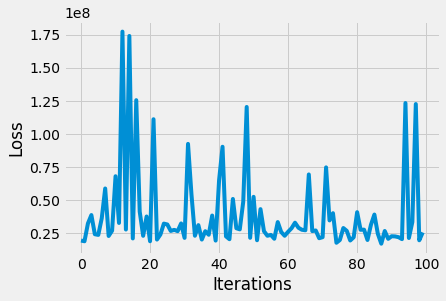

In [11]:
BATCH_SIZE = 1
loader = DataLoader(TensorDataset(torch.tensor(X), torch.tensor(y)), batch_size = BATCH_SIZE, shuffle = True)

AANN1 = AANN1()
AANN1.to(device)

loss_function = nn.MSELoss(reduction = 'mean')
  
optimizer = optim.Adam(AANN1.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 10
losses = []
for epoch in range(epochs):
  for (histogram, _) in loader:      
    # Output of Autoencoder
    AANN1.train()
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    reconstructed = AANN1(histogram)
    reconstructed = reconstructed.squeeze()
    # Calculating the loss
    histogram = histogram.squeeze()
    loss = loss_function(reconstructed, histogram)
      
    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

In [12]:
activation = {}
def get_activation(name):
    def hook(AANN1, input, output):
        activation[name] = output.detach()
    return hook


AANN1.encoder.register_forward_hook(get_activation('encoder'))
Z1 = []
Y1 = []

AANN1.eval()
for (histogram, _) in loader:
    with torch.no_grad():
        histogram = histogram.type(torch.float32).to(device)
        output = AANN1(histogram)
        Z1.append(activation['encoder'].squeeze().detach().cpu().numpy())
        Y1.append(_)

## Training the second layer of the autoencoder

In [13]:
class AANN2(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(32, 24),
            nn.Tanh(),
            nn.Linear(24, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 24),
            nn.Tanh(),
            nn.Linear(24, 32)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


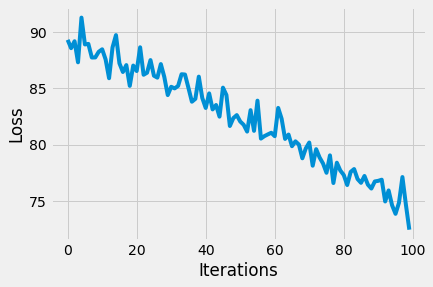

In [14]:
BATCH_SIZE = 1
loader = DataLoader(TensorDataset(torch.tensor(Z1), torch.tensor(Y1)), batch_size = BATCH_SIZE, shuffle = True)

AANN2 = AANN2()
AANN2.to(device)

loss_function = nn.MSELoss(reduction = 'mean')
  
optimizer = optim.Adam(AANN2.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 10
losses = []
for epoch in range(epochs):
  for (histogram, _) in loader:      
    # Output of Autoencoder
    AANN2.train()
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    reconstructed = AANN2(histogram)
    reconstructed = reconstructed.squeeze()
    # Calculating the loss
    histogram = histogram.squeeze()
    loss = loss_function(reconstructed, histogram)
      
    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

In [15]:
activation = {}
def get_activation(name):
    def hook(AANN2, input, output):
        activation[name] = output.detach()
    return hook


AANN2.encoder.register_forward_hook(get_activation('encoder'))
Z2 = []
Y2 = []

AANN2.eval()
for (histogram, _) in loader:
    with torch.no_grad():
        histogram = histogram.type(torch.float32).to(device)
        output = AANN2(histogram)
        Z2.append(activation['encoder'].squeeze().detach().cpu().numpy())
        Y2.append(_)

## Training the third layer of autoencoder

In [16]:
class AANN3(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(16, 12),
            nn.Tanh(),
            nn.Linear(12, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),
            nn.Tanh(),
            nn.Linear(12, 16)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

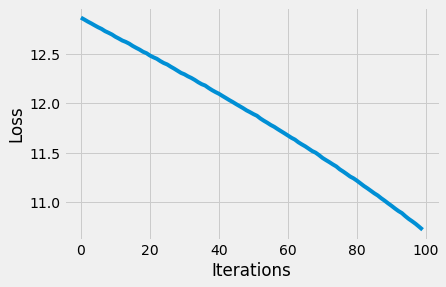

In [17]:
BATCH_SIZE = 1
loader = DataLoader(TensorDataset(torch.tensor(Z2), torch.tensor(Y2)), batch_size = BATCH_SIZE, shuffle = True)

AANN3 = AANN3()
AANN3.to(device)

loss_function = nn.MSELoss(reduction = 'mean')
  
optimizer = optim.Adam(AANN3.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 10
losses = []
for epoch in range(epochs):
  for (histogram, _) in loader:      
    # Output of Autoencoder
    AANN3.train()
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    reconstructed = AANN3(histogram)
    reconstructed = reconstructed.squeeze()
    # Calculating the loss
    histogram = histogram.squeeze()
    loss = loss_function(reconstructed, histogram)
      
    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(losses[:100])

In [12]:
activation = {}
def get_activation(name):
    def hook(AANN3, input, output):
        activation[name] = output.detach()
    return hook


AANN3.encoder.register_forward_hook(get_activation('encoder'))
Z3 = []
Y3 = []

AANN3.eval()
for (histogram, _) in loader:
    with torch.no_grad():
        histogram = histogram.type(torch.float32).to(device)
        output = AANN3(histogram)
        Z3.append(activation['encoder'].squeeze().detach().cpu().numpy())
        Y3.append(_)

In [22]:
class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        AANN1.train()
        AANN2.train()
        AANN3.train()
        self.ae1 = AANN1.encoder
        self.ae2 = AANN2.encoder
        self.ae3 = AANN3.encoder
        self.DNN = nn.Sequential(
            nn.Linear(8, 5),
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        a1 = self.ae1(x)
        a2 = self.ae2(a1)
        a3 = self.ae3(a2)
        ouput = self.DNN(a3)
        return output

In [23]:
BATCH_SIZE = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify = y)
train_dataloader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size = BATCH_SIZE, shuffle = True)

model = StackedAutoEncoder()
model.to(device)
loss_function = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-8)

train_loss_list = list()
epochs = 50
accuracy_metrics = {
  'train': [],
  'test': []
}

for epoch in range(epochs):
    temp_loss_list = list()
    correct_classified = 0
    for x_train, y_train in train_dataloader:
        model.train()
        x_train = x_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.long).to(device)
        optimizer.zero_grad()

        # Output of Autoencoder
        output = model(x_train)
        # Calculating the loss function
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()
        temp_loss_list.append(loss.detach().cpu().numpy())
        max_indices = torch.argmax(output, dim=1)
        correct_classified +=  (max_indices == y_train).float().sum()
          
        # Storing the losses in a list for plotting
    train_loss_list.append(np.average(temp_loss_list))
    accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
    print("epoch:", epoch)
    print("Train Accuracy: ", correct_classified.item() / len(train_dataloader.dataset))
  
correct_classified = 0
model.eval()
test_loss_list = list()
for X_test, y_test in test_dataloader:
    X_test = X_test.type(torch.float32).to(device)
    y_test = y_test.type(torch.long).to(device)

    score = model(X_test)
    loss = loss_function(input=score, target=y_test)

    test_loss_list.append(loss.detach().cpu().numpy())
    max_indices = torch.argmax(score, dim=1)
    correct_classified +=  (max_indices == y_test).float().sum()

accuracy_metrics["test"].append(correct_classified.item() / len(test_dataloader.dataset))
test_loss_list.append(np.average(test_loss_list))

print("Train average loss: %.5f" %train_loss_list[-1])
print("Test average loss: %.5f" %test_loss_list[-1])
print("Test Accuracy: %.5f" %accuracy_metrics['test'][0])
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(train_loss_list)



RuntimeError: ignored